 Importing Libraries

In [3]:
import os, sys, email
import numpy as np 
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
from nltk.stem.porter import PorterStemmer
import regex as re
import nltk

Data Extraction

In [7]:
# Reading envron csv file (from kaggle)
emails_df = pd.read_csv('C:/Users/HP/Downloads/emails_envron/emails.csv')
emails_df

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...
...,...,...
517396,zufferli-j/sent_items/95.,Message-ID: <26807948.1075842029936.JavaMail.e...
517397,zufferli-j/sent_items/96.,Message-ID: <25835861.1075842029959.JavaMail.e...
517398,zufferli-j/sent_items/97.,Message-ID: <28979867.1075842029988.JavaMail.e...
517399,zufferli-j/sent_items/98.,Message-ID: <22052556.1075842030013.JavaMail.e...


Data Exploration

1. Email Informtion Analysis

In [ ]:
print("Shape of dataframe: ",emails_df.shape)
print("Dataset info: \n",emails_df.info())

Shape of dataframe:  (517401, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517401 entries, 0 to 517400
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   file     517401 non-null  object
 1   message  517401 non-null  object
dtypes: object(2)
memory usage: 7.9+ MB
Dataset info: 
 None


In [5]:
# A single message looks like this
print(emails_df['message'][0])

Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>
Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)
From: phillip.allen@enron.com
To: tim.belden@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Tim Belden <Tim Belden/Enron@EnronXGate>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Here is our forecast

 


In [8]:
## Helper functions
def get_text_from_email(msg):
    '''To get the content from email objects'''
    parts = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain':
            parts.append( part.get_payload() )
    return ''.join(parts)

def split_email_addresses(line):
    '''To separate multiple email addresses'''
    if line:
        addrs = line.split(',')
        addrs = frozenset(map(lambda x: x.strip(), addrs))
    else:
        addrs = None
    return addrs

In [9]:
# Parse the emails into a list email objects
messages = list(map(email.message_from_string, emails_df['message']))
emails_df.drop('message', axis=1, inplace=True)
# Get fields from parsed email objects
keys = messages[0].keys()
for key in keys:
    emails_df[key] = [doc[key] for doc in messages]
# Parse content from emails
emails_df['content'] = list(map(get_text_from_email, messages))
# Split multiple email addresses
emails_df['From'] = emails_df['From'].map(split_email_addresses)
emails_df['To'] = emails_df['To'].map(split_email_addresses)

# Extract the root of 'file' as 'user'
emails_df['user'] = emails_df['file'].map(lambda x:x.split('/')[0])
del messages

In [8]:
# New Detailed dataframe of message
emails_df.head()

,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user
0,allen-p/_sent_mail/1.,<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",(phillip.allen@enron.com),(tim.belden@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n,allen-p
1,allen-p/_sent_mail/10.,<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",(phillip.allen@enron.com),(john.lavorato@enron.com),Re:,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,allen-p
2,allen-p/_sent_mail/100.,<24216240.1075855687451.JavaMail.evans@thyme>,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",(phillip.allen@enron.com),(leah.arsdall@enron.com),Re: test,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!,allen-p
3,allen-p/_sent_mail/1000.,<13505866.1075863688222.JavaMail.evans@thyme>,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",(phillip.allen@enron.com),(randall.gay@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s...",allen-p
4,allen-p/_sent_mail/1001.,<30922949.1075863688243.JavaMail.evans@thyme>,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",(phillip.allen@enron.com),(greg.piper@enron.com),Re: Hello,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.,allen-p


In [9]:
# Finding null data
emails_df.isnull().sum()

file                             0
Message-ID                       0
Date                             0
From                             0
To                           21847
Subject                          0
Mime-Version                    29
Content-Type                    29
Content-Transfer-Encoding       29
X-From                          29
X-To                            29
X-cc                            29
X-bcc                           29
X-Folder                        29
X-Origin                        29
X-FileName                      29
content                          0
user                             0
dtype: int64

In [10]:
# remove rows with null values
emails_df = emails_df.dropna()

In [11]:
# remove duplicates
emails_df.drop_duplicates()

,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user
0,allen-p/_sent_mail/1.,<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",(phillip.allen@enron.com),(tim.belden@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n,allen-p
1,allen-p/_sent_mail/10.,<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",(phillip.allen@enron.com),(john.lavorato@enron.com),Re:,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,allen-p
2,allen-p/_sent_mail/100.,<24216240.1075855687451.JavaMail.evans@thyme>,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",(phillip.allen@enron.com),(leah.arsdall@enron.com),Re: test,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!,allen-p
3,allen-p/_sent_mail/1000.,<13505866.1075863688222.JavaMail.evans@thyme>,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",(phillip.allen@enron.com),(randall.gay@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s...",allen-p
4,allen-p/_sent_mail/1001.,<30922949.1075863688243.JavaMail.evans@thyme>,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",(phillip.allen@enron.com),(greg.piper@enron.com),Re: Hello,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.,allen-p
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517396,zufferli-j/sent_items/95.,<26807948.1075842029936.JavaMail.evans@thyme>,"Wed, 28 Nov 2001 13:30:11 -0800 (PST)",(john.zufferli@enron.com),(kori.loibl@enron.com),Trade with John Lavorato,1.0,text/plain; charset=us-ascii,7bit,"Zufferli, John </O=ENRON/OU=NA/CN=RECIPIENTS/C...","Loibl, Kori </O=ENRON/OU=NA/CN=RECIPIENTS/CN=K...",,,"\ExMerge - Zufferli, John\Sent Items",ZUFFERLI-J,john zufferli 6-26-02.PST,This is a trade with OIL-SPEC-HEDGE-NG (John L...,zufferli-j
517397,zufferli-j/sent_items/96.,<25835861.1075842029959.JavaMail.evans@thyme>,"Wed, 28 Nov 2001 12:47:48 -0800 (PST)",(john.zufferli@enron.com),(john.lavorato@enron.com),Gas Hedges,1.0,text/plain; charset=us-ascii,7bit,"Zufferli, John </O=ENRON/OU=NA/CN=RECIPIENTS/C...","Lavorato, John </O=ENRON/OU=NA/CN=RECIPIENTS/C...",,,"\ExMerge - Zufferli, John\Sent Items",ZUFFERLI-J,john zufferli 6-26-02.PST,Some of my position is with the Alberta Term b...,zufferli-j
517398,zufferli-j/sent_items/97.,<28979867.1075842029988.JavaMail.evans@thyme>,"Wed, 28 Nov 2001 07:20:00 -0800 (PST)",(john.zufferli@enron.com),(dawn.doucet@enron.com),RE: CONFIDENTIAL,1.0,text/plain; charset=us-ascii,7bit,"Zufferli, John </O=ENRON/OU=NA/CN=RECIPIENTS/C...","Doucet, Dawn </O=ENRON/OU=NA/CN=RECIPIENTS/CN=...",,,"\ExMerge - Zufferli, John\Sent Items",ZUFFERLI-J,john zufferli 6-26-02.PST,2\n\n -----Original Message-----\nFrom: \tDouc...,zufferli-j
517399,zufferli-j/sent_items/98.,<22052556.1075842030013.JavaMail.evans@thyme>,"Tue, 27 Nov 2001 11:52:45 -0800 (PST)",(john.zufferli@enron.com),(jeanie.slone@enron.com),Calgary Analyst/Associate,1.0,text/plain; charset=us-ascii,7bit,"Zufferli, John </O=ENRON/OU=NA/CN=RECIPIENTS/C...","Slone, Jeanie </O=ENRON/OU=NA/CN=RECIPIENTS/CN...",,,"\ExMerge - Zufferli, John\Sent Items",ZUFFERLI-J,john zufferli 6-26-02.PST,Analyst\t\t\t\t\tRank\n\nStephane Brodeur\t\t\...,zufferli-j


In [12]:
# Shape of dataframe after removing null values
emails_df.shape

(495547, 18)

In [13]:
# Find number of unique values in each columns
for col in emails_df.columns:
    print(col, emails_df[col].nunique())

file 495547
Message-ID 495547
Date 217508
From 19750
To 54746
Subject 152895
Mime-Version 1
Content-Type 2
Content-Transfer-Encoding 3
X-From 26885
X-To 72025
X-cc 33189
X-bcc 126
X-Folder 5127
X-Origin 259
X-FileName 425
content 240079
user 150


In [14]:
# Set index and drop columns with two few values
emails_df = emails_df.set_index('Message-ID')\
    .drop(['file', 'Mime-Version', 'Content-Type', 'Content-Transfer-Encoding'], axis=1)

2. When did people send emails ?

In [11]:
# Parse datetime
import pandas as pd
emails_df['Date'] = pd.to_datetime(emails_df['Date'], infer_datetime_format=True, errors='coerce',utc=True)
emails_df.dtypes

file                                      object
Message-ID                                object
Date                         datetime64[ns, UTC]
From                                      object
To                                        object
Subject                                   object
Mime-Version                              object
Content-Type                              object
Content-Transfer-Encoding                 object
X-From                                    object
X-To                                      object
X-cc                                      object
X-bcc                                     object
X-Folder                                  object
X-Origin                                  object
X-FileName                                object
content                                   object
user                                      object
dtype: object

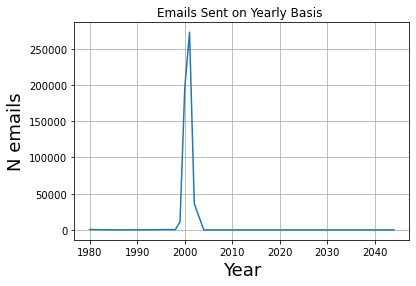

In [22]:
# Yearly emails
import matplotlib.pyplot as plt
ax = emails_df.groupby(emails_df['Date'].dt.year)['content'].count().plot()
ax.set_title("Emails Sent on Yearly Basis ")
ax.grid()
ax.set_xlabel('Year', fontsize=18)
ax.set_ylabel('N emails', fontsize=18)
plt.savefig('Graphs/Yearly Sent Emails.png')


C:\Users\HP\AppData\Local\Temp/ipykernel_21704/1388741198.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0,'Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])


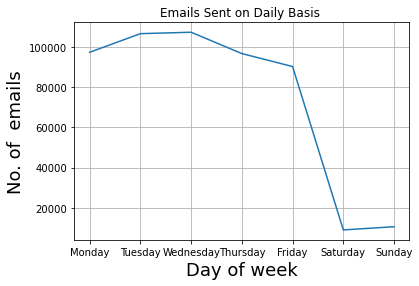

In [23]:
# Daily emails
import matplotlib.pyplot as plt
ax = emails_df.groupby(emails_df['Date'].dt.dayofweek)['content'].count().plot()
ax.set_title("Emails Sent on Daily Basis ")
ax.grid()
ax.set_xlabel('Day of week', fontsize=18)
ax.set_ylabel('No. of  emails', fontsize=18)
ax.set_xticklabels([0,'Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.savefig('Graphs/Weekly Sent Emails.png');


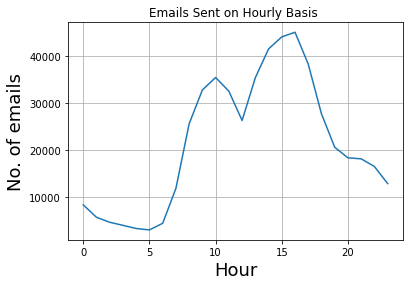

In [17]:
# Hourly emails
ax = emails_df.groupby(emails_df['Date'].dt.hour)['content'].count().plot()
ax.set_title("Emails Sent on Hourly Basis ")
ax.grid()
ax.set_xlabel('Hour', fontsize=18)
ax.set_ylabel('No. of emails', fontsize=18)
plt.savefig("Graphs/Hourly Emails.png")

3. Who send the emails ?

In [24]:
#Creating from_user list
userList = []
userList = emails_df['user'].unique()

In [25]:
#Number of emails sent by each users

count = []
counter = 0 
for l in userList:
    for user in emails_df['user']:
        if user == l:
            counter += 1
    count.append(counter)
    counter = 0

[(28465, 'kaminski-v'), (28234, 'dasovich-j'), (25351, 'kean-s'), (23381, 'mann-k'), (19950, 'jones-t'), (18687, 'shackleton-s'), (13875, 'taylor-m'), (13032, 'farmer-d'), (12436, 'germany-c'), (11830, 'beck-s'), (10827, 'symes-k'), (10655, 'nemec-g'), (8022, 'scott-s'), (8009, 'rogers-b'), (7823, 'bass-e'), (7329, 'sanders-r'), (6490, 'campbell-l'), (6071, 'shapiro-r'), (6054, 'guzman-m'), (5937, 'lay-k')]


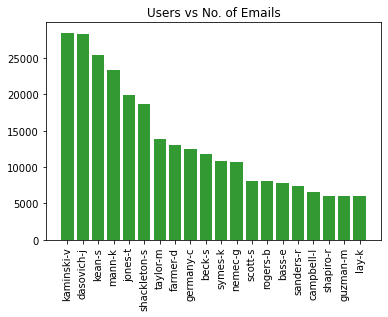

'The histogram shows users vs no. of emails they sent'

<Figure size 432x288 with 0 Axes>

In [28]:
'''Let us take a look at how many email were sent by each user. 
This plot may indicate erratic email usage. 
We plot top 20 users who sent the highest number of emails.'''

new_list = sorted(list(zip(count, userList)), reverse = True)[:20] ##merge both lists and sort top 20, 
print(new_list)
num, mailer = zip(*new_list) ## separate lists previously merged and use them for plotting
mail = range(len(new_list))
plt.bar(mail, num, align = 'center', color ='green', alpha=0.8)
plt.xticks(mail, mailer, rotation='vertical')
plt.title("Users vs No. of Emails")
plt.show()
plt.savefig("Graphs/Users vs No. of Emails.png")
'''The histogram shows users vs no. of emails they sent'''

In [ ]:
# Count words in Subjects and content
from nltk.tokenize.regexp import RegexpTokenizer

tokenizer = RegexpTokenizer(r'(?u)\b\w\w+\b')
emails_df['subject_wc'] = emails_df['Subject'].map(lambda x: len(tokenizer.tokenize(x)))
emails_df['content_wc'] = emails_df['content'].map(lambda x: len(tokenizer.tokenize(x)))

In [ ]:
grouped_by_people = emails_df.groupby('user').agg({
        'content': 'count', 
        'subject_wc': 'mean',
        'content_wc': 'mean',
    })
grouped_by_people.rename(columns={'content': 'N emails', 
                                  'subject_wc': 'Subject word count', 
                                  'content_wc': 'Content word count'}, inplace=True)
grouped_by_people.sort_values('N emails', ascending=False).head()

,N emails,Subject word count,Content word count
user,,,
kaminski-v,27801,4.177044,252.988454
dasovich-j,27463,5.262244,510.389797
kean-s,23896,4.868053,456.919359
mann-k,23302,4.206678,207.139516
jones-t,19739,4.743857,184.884138


4. Who send email to whom ?

In [ ]:
# Sub dataframe to include from and to and date only
sub_df = emails_df[['From', 'To', 'Date']].dropna()
print(sub_df.shape)

# drop emails sending to multiple addresses
sub_df = sub_df.loc[sub_df['To'].map(len) == 1]
print(sub_df.shape)

(495547, 3)
(354595, 3)


In [ ]:
# Grouping dataset
sub_df = sub_df.groupby(['From', 'To']).count().reset_index()

# Unpack frozensets
sub_df['From'] = sub_df['From'].map(lambda x: next(iter(x)))
sub_df['To'] = sub_df['To'].map(lambda x: next(iter(x)))

# rename column
sub_df.rename(columns={'Date': 'count'}, inplace=True)
sub_df.sort_values('count', ascending=False).head(10)

,From,To,count
17914,pete.davis@enron.com,pete.davis@enron.com,9141
38028,vince.kaminski@enron.com,vkaminski@aol.com,4308
28916,enron.announcements@enron.com,all.worldwide@enron.com,2206
28931,enron.announcements@enron.com,all.houston@enron.com,1701
26506,kay.mann@enron.com,suzanne.adams@enron.com,1528
38026,vince.kaminski@enron.com,shirley.crenshaw@enron.com,1190
14347,steven.kean@enron.com,maureen.mcvicker@enron.com,1014
26305,kay.mann@enron.com,nmann@erac.com,980
18547,kate.symes@enron.com,evelyn.metoyer@enron.com,915
18551,kate.symes@enron.com,kerri.thompson@enron.com,859


In [ ]:
# Make a network of email sender and receipients
import networkx as nx
G = nx.from_pandas_edgelist(sub_df, 'From', 'To', edge_attr='count', create_using=nx.DiGraph())
print('Number of nodes: %d, Number of edges: %d' % (G.number_of_nodes(), G.number_of_edges()))

Number of nodes: 25394, Number of edges: 56139


(0.1, 10000.0)

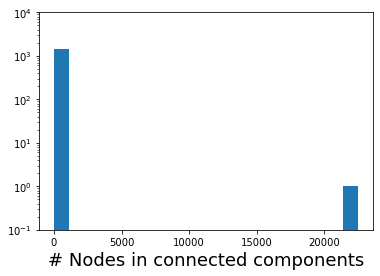

In [ ]:
# Examine connected components in the network
n_nodes_in_cc = []
for nodes in nx.connected_components(G.to_undirected()):
    n_nodes_in_cc.append(len(nodes))

plt.hist(n_nodes_in_cc, bins=20, log=True)
plt.xlabel('# Nodes in connected components', fontsize=18)
plt.ylim([.1,1e4])